In [1]:
import ee
import geemap
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
# import geopandas as gpd

In [2]:
ee.Initialize()

The binary classification sample datasets include the sugarcane farm plots(89) obtained from the Hello Tractor field data

In [3]:
#shp path
tp_src = 'sgcplot.shp'
tp_crop = 'croplabel.shp'
tp_ncrop = 'noncroplabel.shp'

#TODO training data explaination 

#ee object
sgc_ee = geemap.shp_to_ee(tp_src)
crop_ee = geemap.shp_to_ee(tp_crop)
nncrop_ee = geemap.shp_to_ee(tp_ncrop)
#feature collection
crop_fc= sgc_ee.merge(crop_ee)
fc = crop_fc.merge(nncrop_ee)
#define bounding box
bbox = ee.Geometry.bounds(fc)
aoi = bbox
#TODO #read about system.index

In [9]:
#Sentinel 2 Image collection, cloudmask and mosaic
sdate= '2020-05-01'
edate= '2020-08-31'

def cloud_prob():
    innerJoined = ee.Join.inner().apply(**{
        'primary':ee.ImageCollection("COPERNICUS/S2_SR")\
            .filterBounds(aoi)\
                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',10)),
         'secondary': ee.ImageCollection("COPERNICUS/S2_CLOUD_PROBABILITY")\
            .filterBounds(aoi),       
        'condition':ee.Filter.equals(**{
            'leftField':'system:index',
            'rightField':'system:index',
        })
    })
    def mergeBands(joinresult):
        return ee.Image(joinresult.get('primary'))\
            .addBands(joinresult.get('secondary'))
    newCollection = innerJoined.map(mergeBands)
    return ee.ImageCollection(newCollection)

collection = cloud_prob().filterDate(sdate, edate)

def maskcloud(_image):
    cloudProbabilityThreshold =10
    cloudMask = _image.select('probability').lt(cloudProbabilityThreshold)
    return _image.updateMask(cloudMask)

image = collection.map(maskcloud).median()

In [10]:
#Resolution merge of 20m bands to 10m -TODO explain the process
panchro = (image.select('B2').add(image.select('B3'))\
               .add(image.select('B4')).add(image.select('B8')))\
               .divide(4).rename('pan')
image = image.addBands(panchro)

bands = ['B5','B6','B7','B8A','B9','B11','B12']

def sharpen(image):
    kernel = ee.Kernel.square(**{
        'radius': 20,
        'units':'meters'
    })
    toSharpen = image.select(bands)
    pan = image.select('pan')
    meanPan = pan.reduceNeighborhood(**{
        'reducer' : ee.Reducer.mean(),
        'kernel' : kernel
    })
    offset = pan.subtract(meanPan)
    return toSharpen.add(offset)
sharpened = sharpen(image)    

In [11]:
#image c0llection relevant bands (all in 10m), converted to float
bands10m = image.select(['B2','B3','B4','B8'])
imagef = bands10m.addBands(sharpened).divide(10000)
image_feature = imagef.clip(aoi)

In [12]:
#vegetation indices - TODO comment on the use of each VI
def Veg_Index(image_name):
    #NDVI
    ndvi = image_name.expression(
        '(NIR - RED)/(NIR + RED)', {
            'NIR': image_name.select('B8'),
            'RED': image_name.select('B4')
        }).rename('NDVI')
    #EVI
    evi = image_name.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',{
        'NIR': image_name.select('B8'),
        'RED': image_name.select('B4'),
        'BLUE': image_name.select('B2')
    }).rename('EVI')
    #GCVI Green Chlorophyll Vegetation Index - TODO read about GCVI use cases
    gcvi = image_name.expression(
    '(NIR / GREEN) - 1',{
        'NIR':image_name.select('B8'),
        'GREEN':image_name.select('B3')
    }).rename('GCVI')
    #RDGCVI
    rgcvi = image_name.expression(
    '(NIR / REDE1) - 1',{
        'NIR':image_name.select('B8'),
        'REDE1':image_name.select('B5')
    }).rename('RDGCVI')
    #NDWI = (SWIR–NIR)/(SWIR + NIR)
    ndwi = image_name.expression(
        'SWIR/NIR',{
            'SWIR':image_name.select('B12'),
            'NIR':image_name.select('B8')
        }).rename('NDWI')
    return image_name.addBands(ndvi).addBands(evi).addBands(gcvi).addBands(rgcvi).addBands(ndwi)
#image composite of all spectral indices and bands
image_featureWithVI = Veg_Index(image_feature)

In [4]:
#sentinel 1
sdate= '2020-05-01'
edate= '2020-08-31'
VVcollection = ee.ImageCollection('COPERNICUS/S1_GRD')\
    .filter(ee.Filter.eq('instrumentMode', 'IW'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
    .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))\
    .filterMetadata('resolution_meters', 'equals', 10)\
    .filterBounds(aoi)\
    .select(['VV'])

VHcollection = ee.ImageCollection('COPERNICUS/S1_GRD')\
    .filter(ee.Filter.eq('instrumentMode', 'IW'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
    .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))\
    .filterMetadata('resolution_meters', 'equals', 10)\
    .filterBounds(aoi)\
    .select(['VH'])

Sarvv_f = VVcollection.filterDate(sdate,edate).mosaic()
Sarvh_f = VHcollection.filterDate(sdate,edate).mosaic()
smooth_radius = 30
Sarvv = Sarvv_f.focal_mean(smooth_radius, 'circle', 'meters')
Sarvh = Sarvh_f.focal_mean(smooth_radius, 'circle', 'meters')

Sarstack = ee.Image.cat(Sarvh,Sarvv)
Sarratio = Sarvv.divide(Sarvh).rename('Sarratio')
# Sarratio = Sarstack.expression(
#                 'VH/VV',{
#                     'VV':Sarstack.select(Sarvv),
#                     'VH':Sarstack.select(Sarvh)
#                 }).rename('Sarratio')
Sardiff = Sarvv.subtract(Sarvh).rename('Sardiff')
# Sardiff = Sarstack.expression(
#                 'VV-VH',{
#                     'VV':Sarstack.select(Sarvv),
#                     'VH':Sarstack.select(Sarvh)
#                 }).rename('Sardiff')
Sarcomposite = ee.Image.cat(Sarstack, Sarratio,Sardiff)

In [17]:
Opt_SAR_Composite = ee.Image.cat(image_featureWithVI,Sarcomposite)

In [9]:
visparam = {'min': 0.0, 'max': 0.9, 'pallete':['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
    '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
    '012E01', '011D01', '011301']}
Map.addLayer(aoi, {}, 'aoi' )
# Map.addLayer(image_featureWithVI, {'bands': ['B9', 'B11', 'B12'], 'min': 0.0, 'max': 0.3}, 'Original')
# Map.addLayer(image_featureWithVI, {'bands': ['B9', 'B11', 'B12'], 'min': 0.0, 'max': 0.3}, 'Sharpen 1')
# Map.addLayer(image_featureWithVI, {'bands': ['B8', 'B4', 'B3'], 'min': 0.0, 'max': 0.3}, 'False Colour COmposite')
# Map.addLayer(image_featureWithVI, {'bands': ['B4', 'B3', 'B2'], 'min': 0.0, 'max': 0.3}, 'True Colour COmposite')
Map.addLayer(image_featureWithVI, visparam, 'NDVI')
Map.addLayer(image_featureWithVI, visparam, 'GCVI')

In [18]:
#exprot to assest
task = ee.batch.Export.image.toAsset(**{'image':Opt_SAR_Composite,
'description': 'Optical_SAR_Compositeband',
'assetId':'users/aadebowaledaniel/OptSARComposite', 
'scale': 10, 
'crs':'EPSG:32736',                                        
'region':aoi.getInfo()['coordinates'],
'maxPixels': 1e13,
})
task.start()
#Monitor the task
while task.status()['state'] in ['READY', 'RUNNING']:
  print(task.status())
  time.sleep(5)
else:
  print(task.status())

{'state': 'READY', 'description': 'Optical_SAR_Compositeband', 'creation_timestamp_ms': 1624573463385, 'update_timestamp_ms': 1624573463385, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_IMAGE', 'id': 'VT2YGL5A6MIIRNCZXJO4TETQ', 'name': 'projects/earthengine-legacy/operations/VT2YGL5A6MIIRNCZXJO4TETQ'}
{'state': 'READY', 'description': 'Optical_SAR_Compositeband', 'creation_timestamp_ms': 1624573463385, 'update_timestamp_ms': 1624573463385, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_IMAGE', 'id': 'VT2YGL5A6MIIRNCZXJO4TETQ', 'name': 'projects/earthengine-legacy/operations/VT2YGL5A6MIIRNCZXJO4TETQ'}
{'state': 'READY', 'description': 'Optical_SAR_Compositeband', 'creation_timestamp_ms': 1624573463385, 'update_timestamp_ms': 1624573463385, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_IMAGE', 'id': 'VT2YGL5A6MIIRNCZXJO4TETQ', 'name': 'projects/earthengine-legacy/operations/VT2YGL5A6MIIRNCZXJO4TETQ'}
{'state': 'READY', 'description': 'Optical_SAR_Compositeband', 'creation_timestamp_ms': 

{'state': 'RUNNING', 'description': 'Optical_SAR_Compositeband', 'creation_timestamp_ms': 1624573463385, 'update_timestamp_ms': 1624573607414, 'start_timestamp_ms': 1624573485463, 'task_type': 'EXPORT_IMAGE', 'attempt': 1, 'id': 'VT2YGL5A6MIIRNCZXJO4TETQ', 'name': 'projects/earthengine-legacy/operations/VT2YGL5A6MIIRNCZXJO4TETQ'}
{'state': 'RUNNING', 'description': 'Optical_SAR_Compositeband', 'creation_timestamp_ms': 1624573463385, 'update_timestamp_ms': 1624573607414, 'start_timestamp_ms': 1624573485463, 'task_type': 'EXPORT_IMAGE', 'attempt': 1, 'id': 'VT2YGL5A6MIIRNCZXJO4TETQ', 'name': 'projects/earthengine-legacy/operations/VT2YGL5A6MIIRNCZXJO4TETQ'}
{'state': 'RUNNING', 'description': 'Optical_SAR_Compositeband', 'creation_timestamp_ms': 1624573463385, 'update_timestamp_ms': 1624573607414, 'start_timestamp_ms': 1624573485463, 'task_type': 'EXPORT_IMAGE', 'attempt': 1, 'id': 'VT2YGL5A6MIIRNCZXJO4TETQ', 'name': 'projects/earthengine-legacy/operations/VT2YGL5A6MIIRNCZXJO4TETQ'}
{'st

{'state': 'RUNNING', 'description': 'Optical_SAR_Compositeband', 'creation_timestamp_ms': 1624573463385, 'update_timestamp_ms': 1624573682754, 'start_timestamp_ms': 1624573485463, 'task_type': 'EXPORT_IMAGE', 'attempt': 1, 'id': 'VT2YGL5A6MIIRNCZXJO4TETQ', 'name': 'projects/earthengine-legacy/operations/VT2YGL5A6MIIRNCZXJO4TETQ'}
{'state': 'RUNNING', 'description': 'Optical_SAR_Compositeband', 'creation_timestamp_ms': 1624573463385, 'update_timestamp_ms': 1624573682754, 'start_timestamp_ms': 1624573485463, 'task_type': 'EXPORT_IMAGE', 'attempt': 1, 'id': 'VT2YGL5A6MIIRNCZXJO4TETQ', 'name': 'projects/earthengine-legacy/operations/VT2YGL5A6MIIRNCZXJO4TETQ'}
{'state': 'RUNNING', 'description': 'Optical_SAR_Compositeband', 'creation_timestamp_ms': 1624573463385, 'update_timestamp_ms': 1624573682754, 'start_timestamp_ms': 1624573485463, 'task_type': 'EXPORT_IMAGE', 'attempt': 1, 'id': 'VT2YGL5A6MIIRNCZXJO4TETQ', 'name': 'projects/earthengine-legacy/operations/VT2YGL5A6MIIRNCZXJO4TETQ'}
{'st

In [5]:
Map = geemap.Map(center=(0.9613,34.6536),zoom=8)
Map

Map(center=[0.9613, 34.6536], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chil…

In [10]:
Map.addLayer(Imageclassified,{'min':0, 'max':1, 'pallete': ['662A00', 'D8D8D8']}, 'Classification')


In [33]:
#import composite from asset
predimage = ee.Image('users/aadebowaledaniel/OptSARComposite')

In [34]:
# train_bands = predimage.bandNames()#All bands
train_bands = ('NDVI', 'EVI', 'NDWI', 'GCVI', 'RDGCVI', 'VH', 'VV', 'Sarratio', 'Sardiff' )

In [35]:
#continue from here
trainingSample  = predimage.sampleRegions(
    collection = fc,
    properties=['label'],
    scale = 10 
#     geometries = True
)
# trainingSample.size().getInfo()

randtraning = trainingSample.randomColumn('random')
split = 0.7
trainsample = randtraning.filter(ee.Filter.lt('random', split))
testsample = randtraning.filter(ee.Filter.gte('random', split))

#train random forest classifier
classifier = ee.Classifier.smileRandomForest(100).train(trainsample, 'label', train_bands)


#confusion matrix train Accurracy
trainAccuracy = classifier.confusionMatrix()
print('Resubstitution error matrix: ', trainAccuracy.getInfo())
print('Training overall accuracy: ', trainAccuracy.accuracy().getInfo())

#classify features
testclassifier = testsample.classify(classifier)
#cconfusion matrix representing expected accuracy
testAccuracy = testclassifier.errorMatrix('label', 'classification')
print('confusion Matrix', testAccuracy.getInfo())
print('Valdation overall accuracy:', testAccuracy.accuracy().getInfo())

#classify image
Imageclassified = predimage.select(train_bands).classify(classifier)
# altImageclassified = predimage.classify(classifier)

Resubstitution error matrix:  [[1381, 13], [1, 2786]]
Training overall accuracy:  0.9966515187754126
confusion Matrix [[432, 172], [71, 1168]]
Valdation overall accuracy: 0.8681497558328811


In [41]:
#exprot classified image to drive
task = ee.batch.Export.image.toDrive(image=Imageclassified,
                                     description='Classification of Opt_SAR',
                                     scale=10,
                                     region = aoi.getInfo()['coordinates'],
                                     fileNamePrefix='SAR_VIs',
                                     crs='EPSG:32736',
                                     fileFormat='GeoTIFF')
task.start()
#Monitor the task
while task.status()['state'] in ['READY', 'RUNNING']:
  print(task.status())
  time.sleep(5)
else:
  print(task.status())

{'state': 'READY', 'description': 'Classification of Opt_SAR', 'creation_timestamp_ms': 1624580243184, 'update_timestamp_ms': 1624580243184, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_IMAGE', 'id': 'LMMHA53OU3FEQG4HICIUAREB', 'name': 'projects/earthengine-legacy/operations/LMMHA53OU3FEQG4HICIUAREB'}
{'state': 'READY', 'description': 'Classification of Opt_SAR', 'creation_timestamp_ms': 1624580243184, 'update_timestamp_ms': 1624580243184, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_IMAGE', 'id': 'LMMHA53OU3FEQG4HICIUAREB', 'name': 'projects/earthengine-legacy/operations/LMMHA53OU3FEQG4HICIUAREB'}
{'state': 'READY', 'description': 'Classification of Opt_SAR', 'creation_timestamp_ms': 1624580243184, 'update_timestamp_ms': 1624580243184, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_IMAGE', 'id': 'LMMHA53OU3FEQG4HICIUAREB', 'name': 'projects/earthengine-legacy/operations/LMMHA53OU3FEQG4HICIUAREB'}
{'state': 'READY', 'description': 'Classification of Opt_SAR', 'creation_timestamp_ms': 

{'state': 'RUNNING', 'description': 'Classification of Opt_SAR', 'creation_timestamp_ms': 1624580243184, 'update_timestamp_ms': 1624580350631, 'start_timestamp_ms': 1624580285680, 'task_type': 'EXPORT_IMAGE', 'attempt': 1, 'id': 'LMMHA53OU3FEQG4HICIUAREB', 'name': 'projects/earthengine-legacy/operations/LMMHA53OU3FEQG4HICIUAREB'}
{'state': 'RUNNING', 'description': 'Classification of Opt_SAR', 'creation_timestamp_ms': 1624580243184, 'update_timestamp_ms': 1624580350631, 'start_timestamp_ms': 1624580285680, 'task_type': 'EXPORT_IMAGE', 'attempt': 1, 'id': 'LMMHA53OU3FEQG4HICIUAREB', 'name': 'projects/earthengine-legacy/operations/LMMHA53OU3FEQG4HICIUAREB'}
{'state': 'RUNNING', 'description': 'Classification of Opt_SAR', 'creation_timestamp_ms': 1624580243184, 'update_timestamp_ms': 1624580350631, 'start_timestamp_ms': 1624580285680, 'task_type': 'EXPORT_IMAGE', 'attempt': 1, 'id': 'LMMHA53OU3FEQG4HICIUAREB', 'name': 'projects/earthengine-legacy/operations/LMMHA53OU3FEQG4HICIUAREB'}
{'st

{'state': 'RUNNING', 'description': 'Classification of Opt_SAR', 'creation_timestamp_ms': 1624580243184, 'update_timestamp_ms': 1624580534015, 'start_timestamp_ms': 1624580285680, 'task_type': 'EXPORT_IMAGE', 'attempt': 1, 'id': 'LMMHA53OU3FEQG4HICIUAREB', 'name': 'projects/earthengine-legacy/operations/LMMHA53OU3FEQG4HICIUAREB'}
{'state': 'COMPLETED', 'description': 'Classification of Opt_SAR', 'creation_timestamp_ms': 1624580243184, 'update_timestamp_ms': 1624580537517, 'start_timestamp_ms': 1624580285680, 'task_type': 'EXPORT_IMAGE', 'destination_uris': ['https://drive.google.com/'], 'attempt': 1, 'id': 'LMMHA53OU3FEQG4HICIUAREB', 'name': 'projects/earthengine-legacy/operations/LMMHA53OU3FEQG4HICIUAREB'}


In [36]:
vrimp = classifier.explain().getInfo().get('importance') #TODO chart in python

In [37]:
bands = []
vim = []
for x, y in vrimp.items():
    bands.append(x)
    vim.append(y)

cmcm = list(zip(bands,vim))
df = pd.DataFrame(cmcm, columns = ['features', 'mda'])

In [38]:
df['importance'] = (df['mda']/df['mda'].sum())
df = df.sort_values('importance', ascending=True)

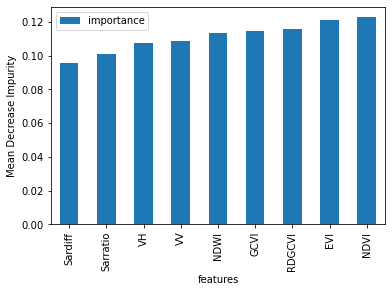

In [39]:
df.plot.bar('features', 'importance', ylabel='Mean Decrease Impurity')
plt.show()

In [ ]:
# Map.addLayer(image, {'bands': ['B4', 'B3', 'B2'], 'min': 0.0, 'max': 0.3, 'gamma': 2}, 'True colour composite')


In [9]:
# cropmask = Imageclassified.eq(1)
# # vis = {'pallete':['#18d848']}
# Map.addLayer(cropmask,{'color':'green'}, 'Crop')

cropmask = Imageclassified.eq(1)

cropmaskdd = cropmask.updateMask(cropmask)

cropmask_vec = cropmaskdd.reduceToVectors(
    geometryType= 'polygon',
    reducer= ee.Reducer.countEvery(),
    scale= 10,
    maxPixels= 1e13,
    geometry= aoi
)
Map.addLayer(cropmask_vec, {'color':'green'}, 'Crop Mask')

In [11]:
cropmask = Imageclassified.eq(1)
# vis = {'pallete':['#18d848']}
Map.addLayer(cropmask,{'color':'green'}, 'Vegetation')

cropmask = Imageclassified.eq(2)

cropmaskdd = cropmask.updateMask(cropmask)

cropmask_vec = cropmaskdd.reduceToVectors(
    geometryType= 'polygon',
    reducer= ee.Reducer.countEvery(),
    scale= 10,
    maxPixels= 1e13,
    geometry= aoi
)
Map.addLayer(cropmask_vec, {'color':'green'}, 'Crop Mask')

In [15]:
# #convert to Vector
# cropmask = Imageclassified.eq(1)

# vector_cropmask = cropmask.updateMask(cropmask).reduceToVectors(
#     reducer=ee.Reducer.countEvery(),
#     geometry= aoi,
#     scale=10,
#     maxPixels=1e13)
# def sim(nna):
#     return nna.simplify(maxError = 100)
# vector_cropmask = vector_cropmask.map(sim)
# cropmaskVec = cropmask.reduceToVectors({
#     # 'geometryType': 'polygon',
#   'reducer': ee.Reducer.countEvery(),
#   'scale': 10,
#   'geometry':aoi,
# })

# vector_img = Imageclassified.unmask(0).reduceToVectors(
#         geometry = aoi,
#         scale = 10,
#         maxPixels = 1e13,
#         bestEffort =True
#     )
# taskvec = ee.batch.Export.table.toAsset(collection=vector_cropmask,
# description= 'Vegetation mask', assetId= 'users/aadebowaledaniel/vegetationmask')
# taskvec.start()
# #Monitor the task
# while taskvec.status()['state'] in ['READY', 'RUNNING']:
#   print(taskvec.status())
#   time.sleep(5)
# else:
#   print(taskvec.status())